# Installation

In [ ]:
# !pip install mira-multiome
# !pip install scanpy
# !pip install torch_geometric

# Imports

In [10]:
# for node vector representation
import mira
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# attributed graph embedding
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from anndata import AnnData

from utils import create_bipartite_graph, convert_to_torch_geometric_data

logging.getLogger().setLevel(logging.ERROR)

torch.cuda.is_available()

False

# Load Data

In [11]:
!gdown --id 1vVxKM9fcXhDnwUuPmkIvVugXbslWuyjd

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1vVxKM9fcXhDnwUuPmkIvVugXbslWuyjd
From (redirected): https://drive.google.com/uc?id=1vVxKM9fcXhDnwUuPmkIvVugXbslWuyjd&confirm=t&uuid=8bfc78b7-c2f6-47f2-be84-a0cab105f0a2
To: /content/e18_mouse_brain_10x_dataset.ad
100% 481M/481M [00:08<00:00, 53.8MB/s]


In [2]:
adata = sc.read_h5ad('e18_mouse_brain_10x_dataset.ad')
rna_data = adata[:,adata.var['feature_types'] == 'Gene Expression']
atac_data = adata[:,adata.var['feature_types'] == 'Peaks']

# Node vector representation
Embedding accessibility data in single cell as node representation vector with topic modelling in MIRA  
https://www.nature.com/articles/s41592-022-01595-z
## Data preprocessing

In [3]:
# Basic preprocessing steps
rna_data.var.index = rna_data.var.index.str.upper()
rna_data.var_names_make_unique()
rna_data = rna_data[:, ~rna_data.var.index.str.startswith('GM')]

sc.pp.filter_cells(rna_data, min_counts = 400)
sc.pp.filter_genes(rna_data, min_cells=15)

rna_data.var['mt'] = rna_data.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_data, qc_vars=['mt'], percent_top=None,
                           log1p=False, inplace=True)

rna_data = rna_data[rna_data.obs.pct_counts_mt < 15, :]
rna_data = rna_data[rna_data.obs.n_genes_by_counts < 8000, :]
sc.pp.filter_genes(rna_data, min_cells=15)

rna_data.raw = rna_data # save raw counts
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)

sc.pp.highly_variable_genes(rna_data, min_disp = -0.1)
rna_data.layers['norm'] = rna_data.X # save normalized count data
rna_data.X = rna_data.raw.X # and reload raw counts
rna_data = rna_data[:, rna_data.var.highly_variable]
rna_data.var['exog_feature'] = rna_data.var.highly_variable # set column "exog_features" to all genes that met dispersion threshold
# set column "highly_variable" to genes that met first criteria and dispersion > 0.8
rna_data.var.highly_variable = (rna_data.var.dispersions_norm > 0.8) & rna_data.var.exog_feature

overlapping_barcodes = np.intersect1d(rna_data.obs_names, atac_data.obs_names) # make sure barcodes are matched between modes
atac_data = atac_data[[i for i in overlapping_barcodes],:]
atac_data = atac_data.copy()

/var/folders/fy/6_fkyxjd7x57hnm8r_j3zxmw0000gn/T/ipykernel_37451/1218275994.py:2: ImplicitModificationWarning: Trying to modify index of attribute `.var` of view, initializing view as actual.
  rna_data.var.index = rna_data.var.index.str.upper()
/Users/gaoyuche/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_simple.py:165: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number
/Users/gaoyuche/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/var/folders/fy/6_fkyxjd7x57hnm8r_j3zxmw0000gn/T/ipykernel_37451/1218275994.py:25: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  rna_data.var['exog_feature'] = rna_data.var.highly_variable # set column "exog_features" to all genes that 

In [5]:
print(rna_data.X[:5, :].toarray())
print(rna_data.shape, atac_data.shape)

[[1.7616894  0.         0.5240745  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [2.2122989  0.         0.         ... 0.         0.5176372  0.        ]
 [2.6869037  0.         0.         ... 0.         0.         0.76104456]
 [1.0559223  0.         0.         ... 0.5595301  0.         0.3183992 ]]
(4706, 5351) (4706, 172193)


## Model Training

In [ ]:
example_atac_model = mira.topics.make_model(
    feature_type = 'accessibility',
    n_samples = atac_data.shape[0],
    n_features = atac_data.shape[1],
).fit(atac_data)

example_atac_model.save('brain_atac_model.pth')

## Predicting and Embedding

In [ ]:
# load saved model to predict topics for accessibility
atac_model = mira.topics.load_model('brain_atac_model.pth')

atac_model.predict(atac_data)
atac_model.get_umap_features(atac_data)

print(atac_data.obsm['X_topic_compositions'].shape)
print(atac_data.obsm['X_umap_features'].shape)

Predicting latent vars: 100%|██████████| 19/19 [01:03<00:00,  3.32s/it]


(4706, 22)
(4706, 21)


In [8]:
# exclude cells that were too small in number
!gdown --id 1GP1KmCauFhYii6LJNPrkU-3ZkIJzYkNq
main_barcodes = pd.read_csv("e18_mouse_brain_10x_main_barcodes.csv", index_col=0, header=0, names=["barcodes"])

rna_main = rna_data[list(main_barcodes["barcodes"])]
atac_main = atac_data[list(main_barcodes["barcodes"])]

print(rna_main.shape, atac_main.shape)

/opt/anaconda3/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GP1KmCauFhYii6LJNPrkU-3ZkIJzYkNq
To: /Users/gaoyuche/Desktop/community detection/attributed graph/e18_mouse_brain_10x_main_barcodes.csv
100%|████████████████████████████████████████| 107k/107k [00:00<00:00, 5.87MB/s]
(4507, 5351) (4507, 172193)


# Attributed Graph Embedding
Graph Covolutional Network

In [11]:
# prepare node representation and adjacency matrix for attributed graph
adjacency_matrix, node_representation = create_bipartite_graph(rna_main.X, atac_main.obsm['X_topic_compositions'])

data = convert_to_torch_geometric_data(adjacency_matrix, node_representation)

In [12]:
class GCNEmbedder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNEmbedder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

input_dim = data.x.size(1)
hidden_dim = 64
output_dim = 16
model = GCNEmbedder(input_dim, hidden_dim, output_dim)

embeddings = model(data)

# CLustering and Visualization

In [13]:
# clustering
num_cells = rna_main.shape[0]
cell_embeddings = embeddings[:num_cells]
cell_embeddings_np = cell_embeddings.cpu().detach().numpy()

num_clusters = 22

# kmeans
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(cell_embeddings_np)
kmeans_cluster_labels = kmeans.labels_

# gmm
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=0)
gmm_cluster_labels = gmm.fit_predict(cell_embeddings_np)

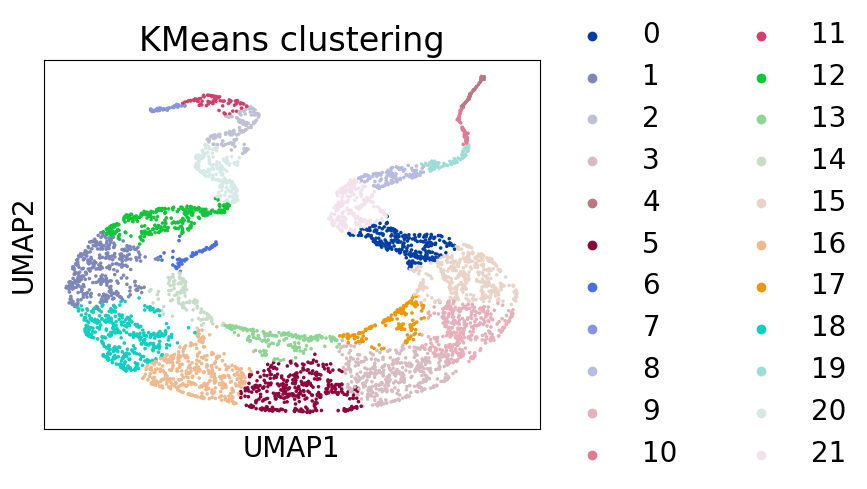

In [14]:
# Visualization
adata = AnnData(X=cell_embeddings_np)
adata.obs['cluster'] = kmeans_cluster_labels.astype(str)

sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cluster', title = 'KMeans clustering')

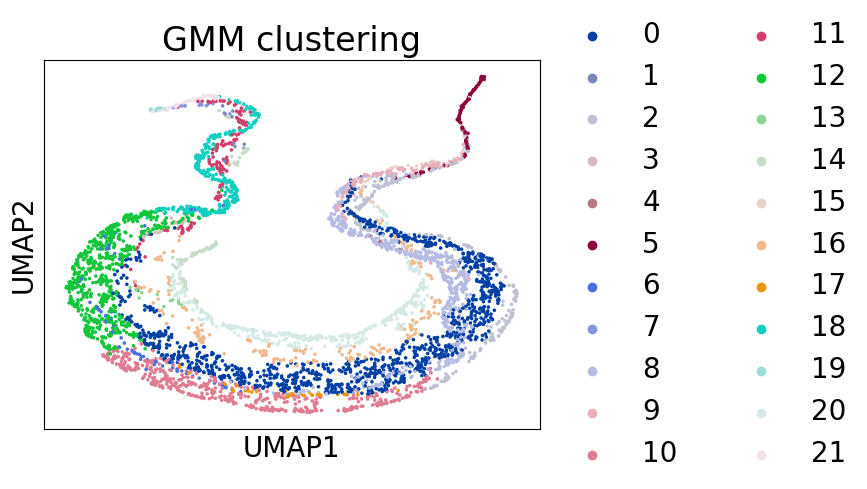

In [15]:
# Visualization
adata = AnnData(X=cell_embeddings_np)
adata.obs['cluster'] = gmm_cluster_labels.astype(str)

sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cluster', title = 'GMM clustering')